In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
import sklearn
import scipy
import statsmodels
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
import evo_etc
from functools import reduce
import multiprocessing

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [3]:
def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [4]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [5]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

In [180]:
# Convenient pickle wrappers
def load_pickle(filename):
    return pickle.load(open(file=filename,mode='rb'))

def dump_pickle(obj,filename):
    return pickle.dump(obj=obj,file=open(file=filename, mode='wb'))

### Visualize models from posterior distribution

In [8]:
model_frame = load_pickle("../results/permuted_smcabc_second_iteration/simulation_skeleton.pkl")

In [11]:
model_skeleton.outfile

0    ../results/permuted_smcabc_res/smcabc_gem_thre...
1    ../results/permuted_smcabc_res/smcabc_gem_thre...
2    ../results/permuted_smcabc_res/smcabc_gem_thre...
3    ../results/permuted_smcabc_res/smcabc_gem_thre...
4    ../results/permuted_smcabc_res/smcabc_gem_thre...
5    ../results/permuted_smcabc_res/smcabc_gem_thre...
6    ../results/permuted_smcabc_res/smcabc_gem_thre...
7    ../results/permuted_smcabc_res/smcabc_gem_thre...
Name: outfile, dtype: object

In [14]:
model_skeleton["model"] = list(map(load_pickle,model_skeleton.outfile))

In [18]:
model_frame = model_skeleton.set_index(["origin","status"])

In [19]:
model_frame

priors  \
origin     status                                                         
unpermuted original   {'O13525_Tm': <abc_etc.RV object at 0x7f374ebc...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374e5c...   
permuted_0 original   {'O13525_Tm': <abc_etc.RV object at 0x7f374dfa...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374dcf...   
permuted_1 original   {'O13525_Tm': <abc_etc.RV object at 0x7f374da4...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374d71...   
permuted_2 original   {'O13525_Tm': <abc_etc.RV object at 0x7f374d47...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374d1c...   

                                                                outfile  \
origin     status                                                         
unpermuted original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_0 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_1 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_2 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   

                                                          model  
origin     status                                                
unpermuted original   <abc_etc.SMCABC object at 0x7f374e81df70>  
           replicate  <abc_etc.SMCABC object at 0x7f374e81db50>  
permuted_0 original   <abc_etc.SMCABC object at 0x7f374e81dd00>  
           replicate  <abc_etc.SMCABC object at 0x7f374e50cdf0>  
permuted_1 original   <abc_etc.SMCABC object at 0x7f374e8bbc10>  
           replicate  <abc_etc.SMCABC object at 0x7f374eb9d0a0>  
permuted_2 original   <abc_etc.SMCABC object at 0x7f374eb9b220>  
           replicate  <abc_etc.SMCABC object at 0x7f374e4d3430>

In [28]:
model_frame.index

MultiIndex([('unpermuted',  'original'),
            ('unpermuted', 'replicate'),
            ('permuted_0',  'original'),
            ('permuted_0', 'replicate'),
            ('permuted_1',  'original'),
            ('permuted_1', 'replicate'),
            ('permuted_2',  'original'),
            ('permuted_2', 'replicate')],
           names=['origin', 'status'])

In [31]:
reference_model = model_frame.loc[("unpermuted","original"),"model"]

In [35]:
models = model_frame.model

In [37]:
models.index

MultiIndex([('unpermuted',  'original'),
            ('unpermuted', 'replicate'),
            ('permuted_0',  'original'),
            ('permuted_0', 'replicate'),
            ('permuted_1',  'original'),
            ('permuted_1', 'replicate'),
            ('permuted_2',  'original'),
            ('permuted_2', 'replicate')],
           names=['origin', 'status'])

In [32]:
def plot_lines_prior_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental',zorder=1)
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    for item in model.simulated_data_t0: 
        plt.plot(dfae_batch.index,item['rae'],color='#1f78b4',zorder=0)

    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [33]:
def plot_lines_prior_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental',zorder=1)
    
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    for item in model.simulated_data_t0: 
        plt.plot(ts,item['ran'],zorder=0,color='#1f78b4')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [34]:
def plot_lines_prior_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])

    #rs0 = np.array(rs0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        if i<2: continue
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental',zorder=1)
        for j,r in enumerate(rs0):
            plt.plot(dfchemo.index,r[i*6:(i+1)*6],color='#1f78b4',zorder=0)
        print(j)
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

('unpermuted', 'original')
0.0018241406250000005


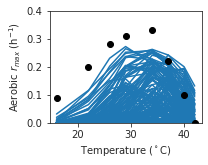

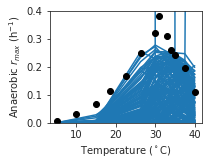

4.260765416666666
143


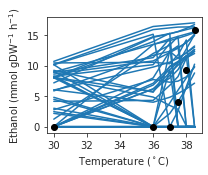

('unpermuted', 'replicate')
0.0018241406250000005


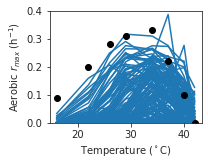

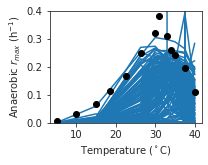

4.260765416666666
143


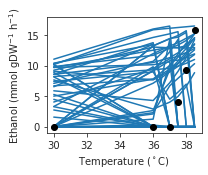

('permuted_0', 'original')
0.0018241406250000005


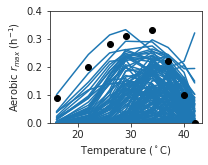

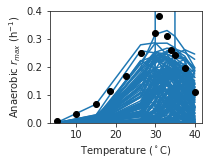

4.260765416666666
143


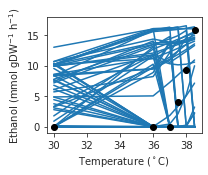

('permuted_0', 'replicate')
0.0018241406250000005


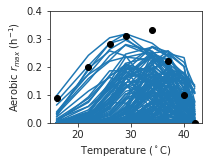

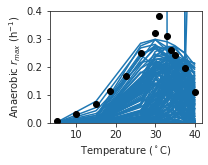

4.260765416666666
143


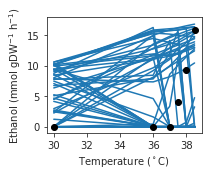

('permuted_1', 'original')
0.0018241406250000005


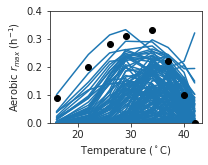

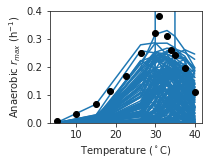

4.260765416666666
143


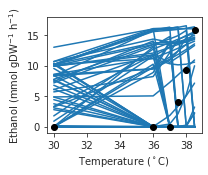

('permuted_1', 'replicate')
0.0018241406250000005


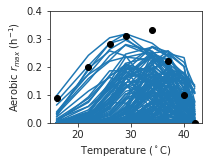

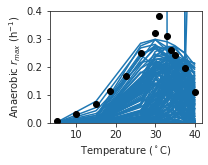

4.260765416666666
143


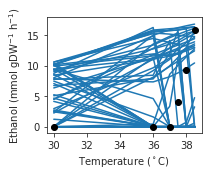

('permuted_2', 'original')
0.0018241406250000005


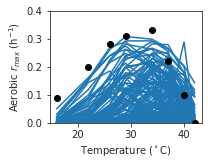

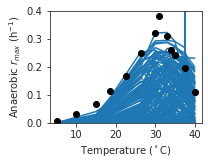

4.260765416666666
127


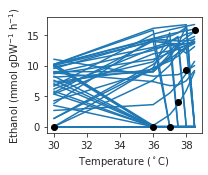

('permuted_2', 'replicate')
0.0018241406250000005


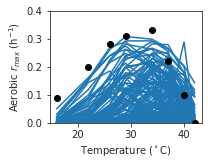

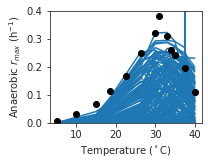

4.260765416666666
127


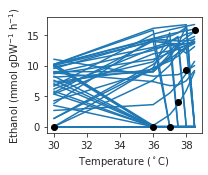

In [38]:
for index, model in models.iteritems():
    print(index)
    plot_lines_prior_ae(model)
    plot_lines_prior_an(model)
    plot_lines_prior_chemostat(model)

In [39]:
!pwd

/home/jakobpp/BayesianGEM/code


In [40]:
def plot_last_population_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental')
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    rs0 = list()
    rs  = list()
    for item in model.simulated_data_t0: rs0.append(item['rae'])
    for item in model.simulated_data: rs.append(item['rae'])

    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    
    plt.plot(dfae_batch.index,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(dfae_batch.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(dfae_batch.index,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(dfae_batch.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [41]:
def plot_last_population_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental')
    
    
    rs0 = list() # prior
    rs = list()  # posterior
    for item in model.simulated_data: rs.append(item['ran'])
    for item in model.simulated_data_t0:rs0.append(item['ran'])
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    print(np.var(dfan_batch.loc[ts,'r_an'])*0.15)
    
    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    plt.plot(ts,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(ts,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(ts,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(ts,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    #plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [42]:
def plot_last_population_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    rs  = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])
    for item in model.simulated_data: rs.append(item['chemostat'])

    #rs0 = np.array(rs0)
    #yt0 = np.mean(rs0,axis=0)
    #yerrt0 = np.std(rs0,axis=0)
    
    #rs = np.array(rs)
    #yt = np.mean(rs,axis=0)
    #yerrt = np.std(rs,axis=0)
    rs0 = np.array(rs0)
    yt0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    yt = np.percentile(rs,[5,50,95],axis=0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[:,i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0[1,:],color='#1f78b4',label='prior')
        plt.fill_between(dfchemo.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
        
        y = yt[:,i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y[1,:],color='#fc8d59',label='posterior')
        plt.fill_between(dfchemo.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [43]:
def plot_legend_growth():
    plt.figure(figsize=(3,2.4))
    plt.scatter([],[],color='k',label='Exp')
    
    plt.plot([],[],color='#1f78b4',label='Prior')
    plt.fill_between([],[],[],alpha=0.8,color='#1f78b4')
    
    plt.plot([],[],color='#fc8d59',label='Posterior')
    plt.fill_between([],[],[],alpha=0.8,color='#fc8d59')
    
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/prior_posterior_legend.pdf',transparent=True)
    plt.show()

('unpermuted', 'original')
0.0018241406250000005


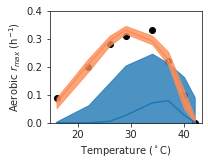

0.0017126156249999997


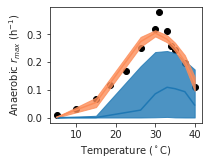

4.260765416666666


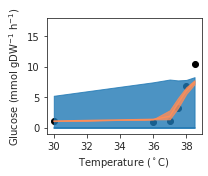

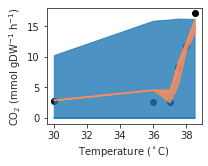

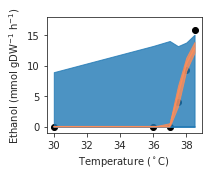

('unpermuted', 'replicate')
0.0018241406250000005


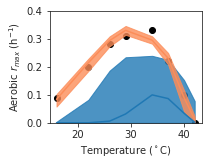

0.0017126156249999997


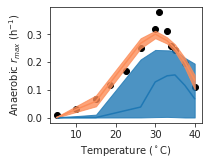

4.260765416666666


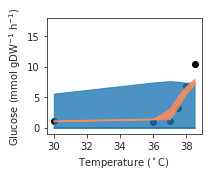

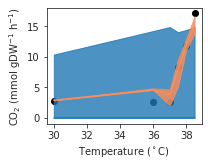

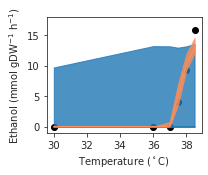

('permuted_0', 'original')
0.0018241406250000005


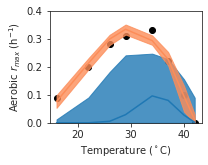

0.0017126156249999997


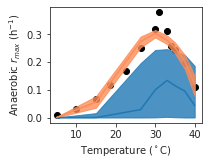

4.260765416666666


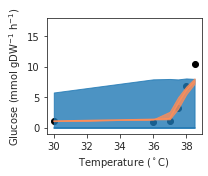

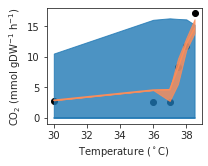

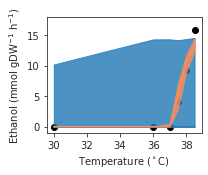

('permuted_0', 'replicate')
0.0018241406250000005


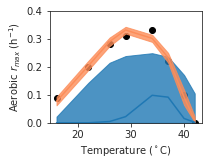

0.0017126156249999997


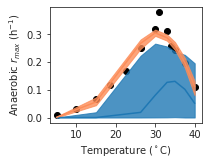

4.260765416666666


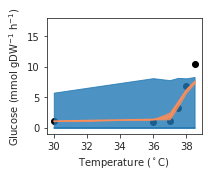

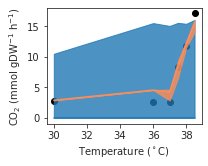

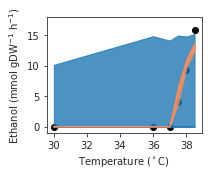

('permuted_1', 'original')
0.0018241406250000005


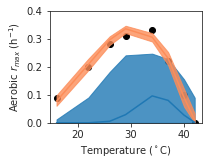

0.0017126156249999997


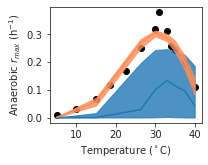

4.260765416666666


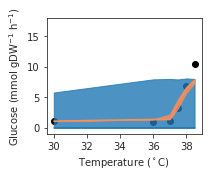

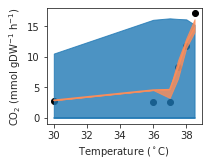

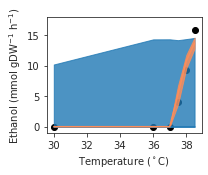

('permuted_1', 'replicate')
0.0018241406250000005


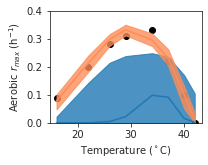

0.0017126156249999997


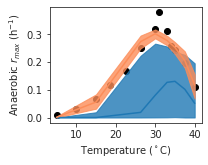

4.260765416666666


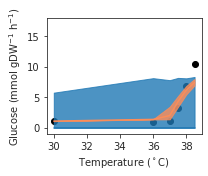

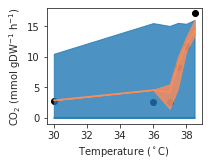

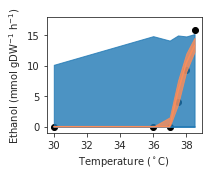

('permuted_2', 'original')
0.0018241406250000005


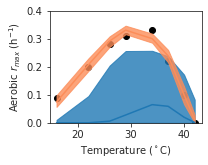

0.0017126156249999997


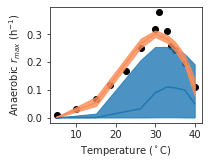

4.260765416666666


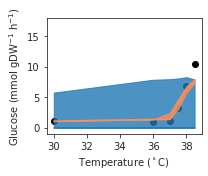

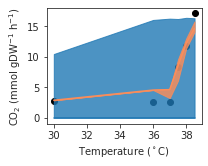

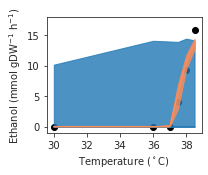

('permuted_2', 'replicate')
0.0018241406250000005


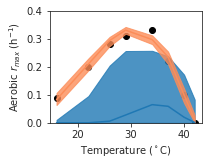

0.0017126156249999997


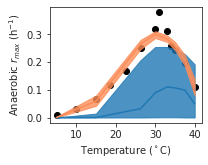

4.260765416666666


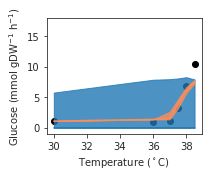

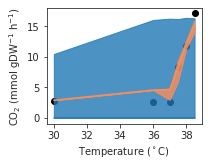

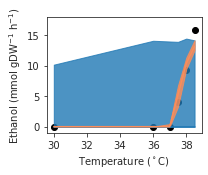

In [45]:
for index, model in models.iteritems():
    print(index)
    plot_last_population_ae(model)
    plot_last_population_an(model)
    plot_last_population_chemostat(model)
    

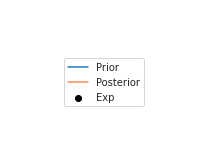

In [46]:
 plot_legend_growth()

In [206]:
model_frame

priors  \
origin     status                                                         
unpermuted original   {'O13525_Tm': <abc_etc.RV object at 0x7f374ebc...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374e5c...   
permuted_0 original   {'O13525_Tm': <abc_etc.RV object at 0x7f374dfa...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374dcf...   
permuted_1 original   {'O13525_Tm': <abc_etc.RV object at 0x7f374da4...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374d71...   
permuted_2 original   {'O13525_Tm': <abc_etc.RV object at 0x7f374d47...   
           replicate  {'O13525_Tm': <abc_etc.RV object at 0x7f374d1c...   

                                                                outfile  \
origin     status                                                         
unpermuted original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_0 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_1 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   
permuted_2 original   ../results/permuted_smcabc_res/smcabc_gem_thre...   
           replicate  ../results/permuted_smcabc_res/smcabc_gem_thre...   

                                                          model  \
origin     status                                                 
unpermuted original   <abc_etc.SMCABC object at 0x7f374e81df70>   
           replicate  <abc_etc.SMCABC object at 0x7f374e81db50>   
permuted_0 original   <abc_etc.SMCABC object at 0x7f374e81dd00>   
           replicate  <abc_etc.SMCABC object at 0x7f374e50cdf0>   
permuted_1 original   <abc_etc.SMCABC object at 0x7f374e8bbc10>   
           replicate  <abc_etc.SMCABC object at 0x7f374eb9d0a0>   
permuted_2 original   <abc_etc.SMCABC object at 0x7f374eb9b220>   
           replicate  <abc_etc.SMCABC object at 0x7f374e4d3430>   

                                                            particle_df  
origin     status                                                        
unpermuted original           O13525_Tm  O13525_Topt   O13525_dCpt  ...  
           replicate          O13525_Tm  O13525_Topt   O13525_dCpt  ...  
permuted_0 original           O13525_Tm  O13525_Topt   O13525_dCpt  ...  
           replicate          O13525_Tm  O13525_Topt  O13525_dCpt   ...  
permuted_1 original           O13525_Tm  O13525_Topt  O13525_dCpt   ...  
           replicate          O13525_Tm  O13525_Topt  O13525_dCpt   ...  
permuted_2 original           O13525_Tm  O13525_Topt  O13525_dCpt   ...  
           replicate          O13525_Tm  O13525_Topt  O13525_dCpt   ...

In [215]:
# Saving modeling frame for future use
dump_pickle(model_frame,"../results/permuted_smcabc_res/result_model_frame.pkl")

### Visualize particle population

In [171]:
def build_a_dataframe_for_all_particles(results, n_priors = 128, r2_threshold = 0.9, convert_results=False):
    columns = list(results.all_particles[0].keys())
    columns.sort()
    print("Iterating over particles")
    data = list()
    for p in results.all_particles:
        if convert_results:
            p_refined = evo_etc.convert_to_raw_particle(p)
        else:
            p_refined = p
        data.append([p_refined[k] for k in columns])
    print("Creating Data Frame")
    df = pd.DataFrame(data=data,columns=columns)
    df['r2'] = results.all_distances
    print(df.shape)
    
    # Remove samples with a R2 score smaller than -3
    print("Doing filtering and labelling of Data Frame")
    df['r2'] = -df['r2']
    sel_index = df.index[df['r2']>-3]    
    df = df.loc[sel_index,:]
    df["period"] = "Intermediate"
    df.loc[:n_priors,"period"] = "Prior"
    df.loc[df["r2"] > r2_threshold,"period"] = 'Posterior'
    print(df.shape)

    return df

In [172]:
def combine_dataframes_for_models(df_dict):
    # augmented_df_list =[ df.assign(model = lambda df: label)  for df, label in zip(df_list, index)]
    augmented_df_dict = {label: df.copy() for label, df in df_dict.items()}
    print("Copying done")
    for label, df in augmented_df_dict.items():
        df["model"] = label
        df.reset_index()
    print("Labelling done")
    return pd.concat(augmented_df_dict.values(), ignore_index=True)

In [173]:
def perform_pca_on_parameters(df):
    # 1. normalize all columns to a standard normal distribution
    X, y, model, period = df.values[:,:-3], df.values[:,-3], df.values[:,-2], df.values[:,-1]
    X_n = np.zeros_like(X)    
    for i in range(X_n.shape[1]): X_n[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    pca = PCA(n_components=2)
    PCS = pca.fit_transform(X_n)
    print(pca.explained_variance_ratio_)
    return PCS, pca.explained_variance_ratio_

In [ ]:
with multiprocessing.Pool(10) as p:
    particle_df_map = p.map(build_a_dataframe_for_all_particles,model_frame.model)
    model_frame["particle_df"] = list(particle_df_map)

Exception ignored in: <function _releaseLock at 0x7f379bfb7280>
Traceback (most recent call last):
  File "/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-48:
Process ForkPoolWorker-46:
Process ForkPoolWorker-47:
Process ForkPoolWorker-44:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-42:
Traceback (most recent call last):
  File "/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jakobpp/miniconda3/envs/etcFBA/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:


In [66]:
unique_origins = model_frame.index.get_level_values("origin").unique()

Index(['unpermuted', 'permuted_0', 'permuted_1', 'permuted_2'], dtype='object', name='origin')

In [156]:
job_dict.keys()

dict_keys(['permuted_0', 'permuted_1', 'permuted_2', 'unpermuted'])

In [201]:
def df_dict_helper(series):
        df_dict = {index: value for index, value in series.iteritems()}
        combined_df = combine_dataframes_for_models(df_dict)
        PCS, EV = perform_pca_on_parameters(combined_df)
        # This is a dirty trick to prevent variable unpacking and throwing away
        # the EV part of the result
        return [PCS, EV]

In [ ]:
with multiprocessing.Pool(4) as p:
    job_dict = {name: group[name] for name, group in model_frame["particle_df"].groupby(level="origin")}
    pca_replication_ordinations = dict(job_dict.keys(), p.map(df_dict_helper, job_dict.values()))

Copying done
Labelling done
Copying done
Labelling done
Copying done

Labelling doneCopying done
Labelling done
[0.07141841 0.00918536]
[0.07580786 0.00771273]


In [205]:
type(pca_replication_ordinations)

pandas.core.series.Series

In [214]:
model_frame.loc[""]

KeyError: 'original'

In [ ]:
dump_pickle(pca_replication_ordinations,'../results/pca_replication_ordinations')

In [160]:
i=1
plt.figupca_replication_ordinationsfigsize=(3.,2.4))
markers = ["o","v","^","<"]
marker_dict = {'original': 'o', 'replicate': "v"}
for origin, (PCS, EV) in pca_replication_ordinations.iteritems():
    plt.subplot(2,2,i)
    for label in ['original', 'replicate']:
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(label_idxs.shape)
        # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
        plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                    color='grey',alpha=0.1,label='Intermediate',marker=marker)
        plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                    color='#fc8d59',label='Posterior',marker=marker)
        plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
    plt.xticks(np.arange(-10,20,5))
    plt.title(origin)
    plt.tight_layout()
plt.show()

NameError: name 'combined_index' is not defined

<Figure size 216x172.8 with 0 Axes>

In [190]:
combined_df = combine_dataframes_for_models(combined_df_dict)

Copying done
Labelling done


In [191]:
# pickle.dump(combined_df,open("../results/combined_permuted_df.pkl", 'wb'))

In [194]:
PCS,EV = perform_pca_on_parameters(combined_df)

[0.0736283 0.0260408]


In [195]:
y = combined_df.values[:,-3]
period = combined_df.values[:,-1]
model = combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [196]:
period.shape

(150001,)

(107458,)
(14178,)
(14191,)
(14174,)


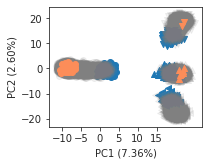

In [200]:
plt.figure(figsize=(3.,2.4))
markers = ["o","v","^","<"]
marker_dict = {label: marker for label, marker in zip(combined_index, markers)}
for label in combined_index:
    label_idxs = np.nonzero(model == label)[0]
    marker = marker_dict[label]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    print(label_idxs.shape)
    # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
    # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
    plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
    plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                color='grey',alpha=0.1,label='Intermediate',marker=marker)
    plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                color='#fc8d59',label='Posterior',marker=marker)
plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
# plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
plt.xticks(np.arange(-10,20,5))
plt.tight_layout()
#plt.savefig('../figures/pca.pdf')
plt.savefig('../figures/pca.png',dpi=300)
plt.show()

In [121]:
marker_dict

{'prior': 'o', 'permuted_0': 'v', 'permuted_1': '^', 'permuted_2': '<'}

## $R^2$ convergence plots

In [20]:
def r2_on_data(Yobs, simulated_data_one):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in Yobs]
    return np.mean(r2_diff_dbs)

In [21]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [22]:
Yobs

{'rae': array([0.09, 0.2 , 0.28, 0.31, 0.33, 0.22, 0.1 , 0.  ]),
 'chemostat': array([ 1.12,  0.87,  1.06,  3.24,  6.85, 10.4 ,  2.74,  2.55,  2.49,
         8.28, 11.65, 17.13,  0.  ,  0.  ,  0.  ,  4.11,  9.34, 15.82]),
 'ran': array([0.008, 0.068, 0.25 , 0.319, 0.309, 0.242, 0.195, 0.111])}

In [23]:
{key: len(Yobs[key]) for key in Yobs}

{'rae': 8, 'chemostat': 18, 'ran': 8}

In [24]:
sample_model = models[0]

In [25]:
example_simulation = sample_model.all_simulated_data[0]

In [26]:
example_simulation

{'rae': array([0.        , 0.        , 0.00236753, 0.00990154, 0.05119745,
        0.08653925, 0.11197021, 0.01784027]),
 'chemostat': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'ran': array([0.00000000e+00, 3.04852302e-06, 2.75928181e-03, 1.54702434e-02,
        4.66794574e-02, 8.19530616e-02, 1.26125062e-01, 1.24047895e-01])}

In [27]:
{key: len(example_simulation[key]) for key in example_simulation}

{'rae': 8, 'chemostat': 18, 'ran': 8}

In [28]:
Yobs['ran']

array([0.008, 0.068, 0.25 , 0.319, 0.309, 0.242, 0.195, 0.111])

In [29]:
r2_score(Yobs['ran'], example_simulation['ran'])

-1.8168203844478752

In [30]:
r2_on_data(Yobs, example_simulation)

-1.684044343451914

In [102]:
def plot_convergence_inner(model, maxiter, offset = 128, generation_size = 100, ind_start = 0, label = None):
    # Offset: Number of newly generated particles per generation
    r2s = []
    ind = ind_start
    i = 0
    # This is a cleaver trick to avoid redoing calculations for every iterations which
    # turns out to be very time-consuming.
    r2s_history = np.array([r2_on_data(Yobs, item) if item is not None else 0 for
                            item in model.all_simulated_data[:offset*maxiter]])
    r2s_history_argsorted = np.argsort(r2s_history)
    while ind < len(model.all_simulated_data):
        i += 1
        if i > maxiter:
            break
        # This is a mask ensuring data created after the interation are excluded
        filter_mask = r2s_history_argsorted < ind + offset
        r2s_now = r2s_history[r2s_history_argsorted[filter_mask]][-generation_size:]
        r2s.append(r2s_now)
        ind += offset
    y = np.array(r2s)
    yp = np.percentile(y,[5,50,95],axis=1)
    plt.plot(np.arange(len(r2s)),yp[1,:], label = label)
    plt.fill_between(np.arange(len(r2s)),yp[0,:],yp[2,:],alpha=0.5)

In [32]:
def plot_convergence(model, maxiter=100):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter)
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.tight_layout()
    plt.show()

In [33]:
def plot_convergence_and_compare(model, reference_model, maxiter=100, legend = True):
    plt.figure(figsize=(3,2.4))
    plot_convergence_inner(model,maxiter, label = 'permuted priors')
    plot_convergence_inner(reference_model,maxiter, label = 'unpermuted priors')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend()
    plt.tight_layout()
    plt.show()

In [34]:
for model in models:
    plot_convergence_and_compare(model, reference_model=reference_model)

NameError: name 'reference_model' is not defined

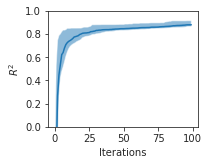

In [301]:
plot_convergence(reference_model, maxiter=100)

# Bayesian interpolation experiments

In [125]:
bayesian_interpolation_results = pickle.load(open("../results/bayesian_interpolation_results.pkl",'rb'))

In [127]:
type(bayesian_interpolation_results)

pandas.core.frame.DataFrame

In [128]:
bayesian_interpolation_results.columns

Index(['from', 'to', 'results'], dtype='object')

In [131]:
sample_result = bayesian_interpolation_results['results'][0]

In [132]:
sample_result

[    ratio  distances                                     simulated_data
 0     0.0  -0.924307  {'rae': [0.07670013694791568, 0.19657819762923...
 1     0.1  -0.553117  {'rae': [0.11105517314104515, 0.23751452176804...
 2     0.2  -0.378932  {'rae': [0.12679704757605173, 0.25877563888639...
 3     0.3  -0.304716  {'rae': [0.13935545078396147, 0.28152354492784...
 4     0.4  -0.235445  {'rae': [0.1543960970709842, 0.301877904153871...
 5     0.5  -0.183336  {'rae': [0.16478031169781854, 0.31762092377413...
 6     0.6  -0.173578  {'rae': [0.1660606230827364, 0.323007644912010...
 7     0.7  -0.217908  {'rae': [0.15818611615282138, 0.32055138967029...
 8     0.8  -0.310377  {'rae': [0.1392534187474875, 0.307389442527935...
 9     0.9  -0.631193  {'rae': [0.10964283982587056, 0.27465108519379...
 10    1.0  -0.906146  {'rae': [0.06430152639241825, 0.21760039746348...,
     ratio  distances                                     simulated_data
 0     0.0  -0.900484  {'rae': [0.0911078340047246

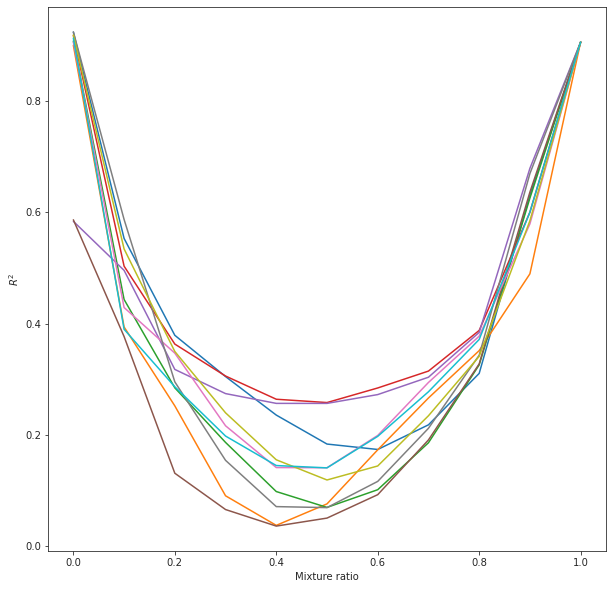

In [134]:
plt.figure(figsize=(10,10))
for result in sample_result:
    plt.plot(result['ratio'],-result['distances'])
    plt.xlabel('Mixture ratio')
    plt.ylabel('$R^2$')
plt.show()

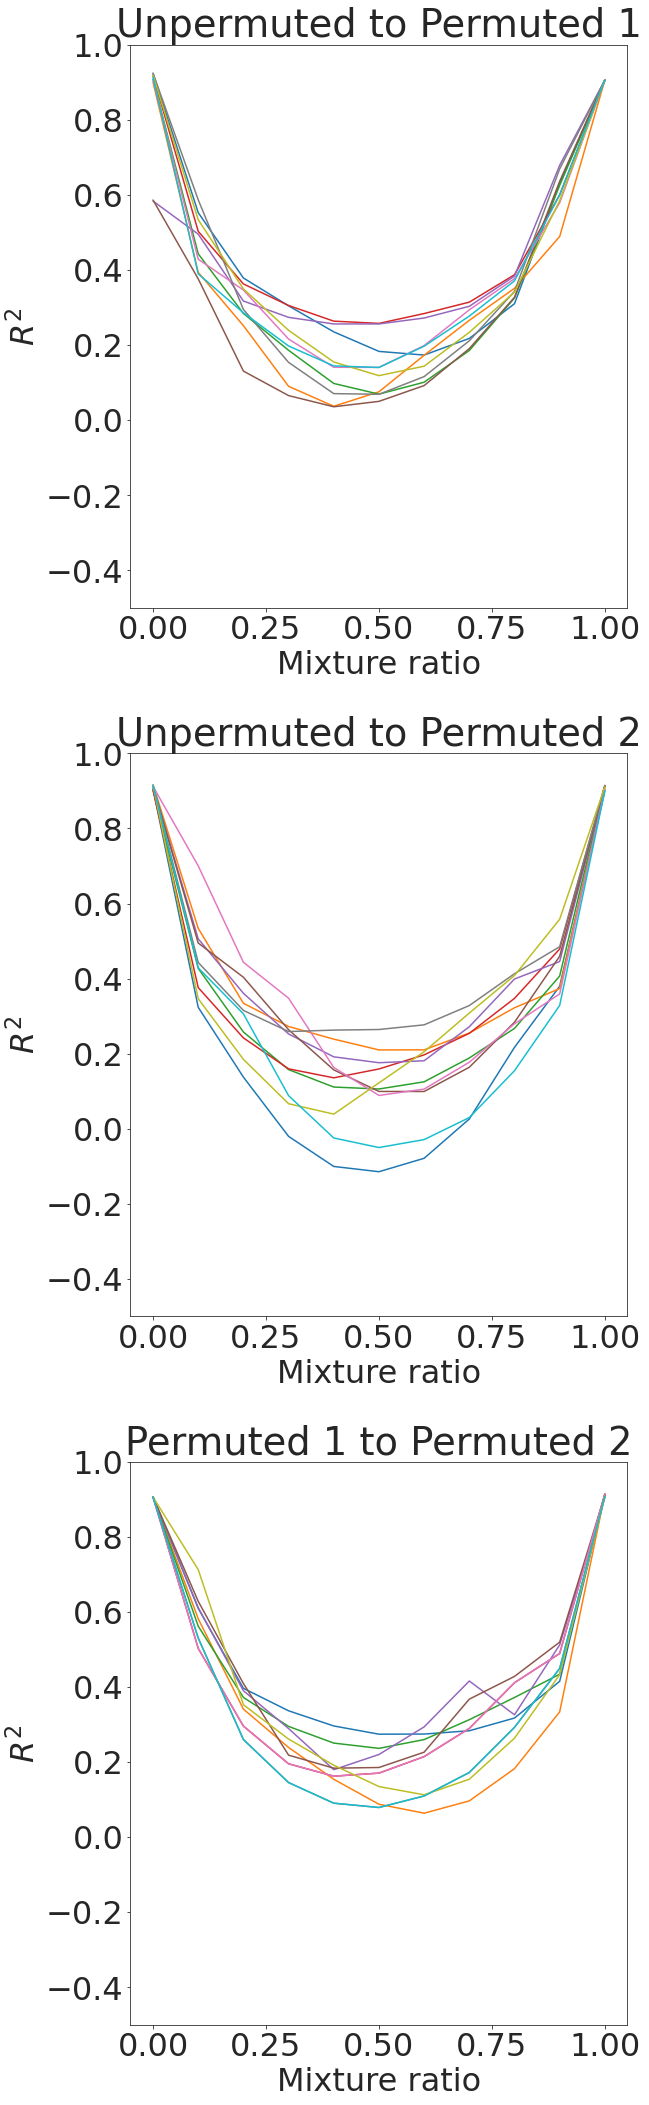

In [163]:
plt.figure(figsize=(10,30))
proper_names = {'unpermuted': "Unpermuted", 'permuted_0': "Permuted 1", 'permuted_1': "Permuted 2"}
plt.rcParams.update({'font.size': 32})
i = 1
for from_model, to_model, results in bayesian_interpolation_results.itertuples(index=False):
    plt.subplot(3,1,i)
    i += 1
    plt.xlabel('Mixture ratio')
    plt.ylabel('$R^2$')
    plt.title(f"{proper_names[from_model]} to {proper_names[to_model]}")
    plt.ylim([-.5,1])
    for result in results:
        plt.plot(result['ratio'],-result['distances'])
plt.tight_layout()
plt.savefig("../figures/bayesian_interpolation.pdf")
plt.show()
    

Please observe: The consensus solution is not neccessarily a good one even though it is an average of better solutions.

# Results of evolutionary algorithm

In [50]:
evolution_model = pickle.load(open('../results/smcevo_gem_three_conditions_save_all_particles.pkl','rb'))

In [55]:
evolution_model.generation_size

100

In [56]:
evolution_model.generations

134

In [57]:
len(evolution_model.population)

134

In [60]:
list(map(len,evolution_model.population))[0:10]

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

In [61]:
len(evolution_model.all_particles)

6750

In [68]:
(len(evolution_model.all_particles) - 50) / evolution_model.generations # 50 new children per generations

50.0

In [67]:
len(evolution_model.all_particles) % evolution_model.generations

50

In [233]:
evolution_model.generations

134

In [64]:
type(evolution_model.all_particles[0])

dict

In [227]:
def plot_convergence_and_compare_evolution(model, reference_model, maxiter=100, legend = True):
    plot_convergence_inner(model, offset=50, generation_size=100, maxiter=maxiter, ind_start = 50, label = 'Evolutionary')
    plot_convergence_inner(reference_model, maxiter=maxiter, label = 'Bayesian')
    plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend(loc="lower right")
    plt.tight_layout()
    return fig

In [72]:
evolution_model

In [73]:
reference_model

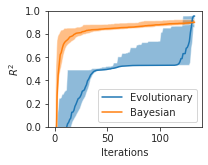

In [228]:
fig = plt.figure(figsize=(3,2.4))
evo_convergence_figure = plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = evolution_model.generations)

In [123]:
evolution_df_dict = {'bayesian': build_a_dataframe_for_all_particles(reference_model),
                     'evolution': build_a_dataframe_for_all_particles(evolution_model,n_priors=50, r2_threshold=0.9, convert_results=True)}
evolution_combined_df = combine_dataframes_for_models(evolution_df_dict)

Iterating of particles
Creating Data Frame
(107904, 2293)
Doing filtering and labelling of Data Frame
(107458, 2294)
Iterating of particles
Creating Data Frame
(6750, 2293)
Doing filtering and labelling of Data Frame
(6147, 2294)
Copying done
Labelling done


In [124]:
evolution_combined_df

,O13525_Tm,O13525_Topt,O13525_dCpt,P00044_Tm,P00044_Topt,P00044_dCpt,P00045_Tm,P00045_Topt,P00045_dCpt,P00127_Tm,...,Q99258_dCpt,Q99312_Tm,Q99312_Topt,Q99312_dCpt,Q99321_Tm,Q99321_Topt,Q99321_dCpt,r2,period,model
0,323.383375,316.376290,-6282.961180,319.536771,303.624184,-6485.608261,330.836389,323.643022,-4013.327405,323.022442,...,-8293.810880,334.286147,329.997339,-6350.806882,321.661931,320.956646,-4880.532399,-1.281283,Prior,bayesian
1,323.225380,295.237549,-7308.050079,320.498313,318.548389,-7655.123502,330.136310,317.070954,-7383.973179,322.926765,...,-7862.861663,326.575802,299.750337,-6090.819228,328.073013,304.599145,-4868.482107,-0.651635,Prior,bayesian
2,317.676145,300.966752,-5635.864994,315.316548,297.833563,-9400.779200,329.843124,306.963812,-7164.439107,330.716702,...,-10490.758989,317.922504,300.270472,-2994.035078,326.335111,301.511659,-10053.456135,-1.951493,Prior,bayesian
3,317.902032,299.642782,-7449.385914,323.187804,293.599385,-7362.945481,321.493197,321.158309,-7024.974895,322.485356,...,-6567.463080,315.149925,306.500383,-4415.126780,324.659219,316.925327,-4196.536122,-1.392736,Prior,bayesian
4,321.567154,300.674084,-8399.496403,322.737474,314.142100,-7360.059564,337.422262,333.557588,-7726.017234,318.537663,...,-4017.897784,320.487330,290.088160,-3672.930047,328.996384,307.497107,-2400.047056,-1.902613,Prior,bayesian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113600,327.366486,321.296298,-5974.809148,321.928354,313.313639,-10438.955642,324.949918,311.821975,-5355.490822,325.080898,...,-6839.365293,323.694039,306.877547,-5146.794671,325.972039,317.668715,-6089.503792,0.908160,Posterior,evolution
113601,327.366486,321.296298,-5974.809148,321.928354,313.313639,-10438.955642,324.949918,311.821975,-5355.490822,325.080898,...,-6839.365293,323.694039,306.877547,-5146.794671,324.429633,317.668715,-6089.503792,0.953386,Posterior,evolution
113602,331.444192,320.775587,-5846.432184,321.965572,313.311729,-10201.984569,325.063705,311.910532,-5344.776799,325.081315,...,-6938.335992,323.686019,307.395799,-5146.588332,324.259700,317.660201,-6096.258364,-0.886124,Intermediate,evolution
113603,327.369057,320.775587,-5846.432184,321.965572,313.311729,-10201.984569,325.063705,311.910532,-5344.776799,325.081315,...,-6938.335992,323.686019,307.395799,-5146.588332,324.259700,317.660201,-6096.258364,0.954148,Posterior,evolution


In [125]:
PCS_evo,EV_evo = perform_pca_on_parameters(evolution_combined_df)

[0.0319178  0.00559971]


In [142]:
y = evolution_combined_df.values[:,-3]
model = evolution_combined_df.values[:,-1]
period = evolution_combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

(107458,)
(6147,)


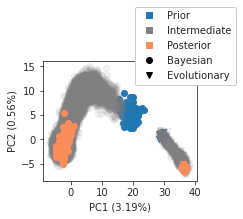

In [213]:
evo_pca_figure = plt.figure(figsize=(3,2.4))
markers = ["o","v"]
marker_dict = {'bayesian': "o", 'evolution': 'v'}
def create_evo_pca_plot():
    for label in evolution_df_dict.keys():
        label_idxs = np.nonzero(model == label)[0]
        marker = marker_dict[label]
        this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
        print(label_idxs.shape)
            # plt.scatter(PCS[:,0],PCS_evo[:,1],color='grey',alpha=0.2)
        # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
        plt.scatter(PCS_evo[this_idxs['Prior'],0],PCS_evo[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
        plt.scatter(PCS_evo[this_idxs["Intermediate"],0],PCS_evo[this_idxs["Intermediate"], 1],
                    color='grey',alpha=0.1,label='Intermediate',marker=marker)
        plt.scatter(PCS_evo[this_idxs['Posterior'],0],PCS_evo[this_idxs['Posterior'], 1],
                    color='#fc8d59',label='Posterior',marker=marker)
    plt.xlabel('PC1 ({:.2f}%)'.format(EV_evo[0]*100))
    plt.ylabel('PC2 ({:.2f}%)'.format(EV_evo[1]*100))
    # plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
    plt.xticks(np.arange(-10,50,10))
    plt.tight_layout()
    colors = ['#1f78b4', 'grey', '#fc8d59']
    labels = ["Prior", "Intermediate", 'Posterior'] + ['Bayesian', "Evolutionary"]
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    handles = [f("s", color) for color in colors]
    handles += [f(marker, "k") for marker in markers]
    plt.legend(handles, labels, loc=(.6,.8), framealpha=1)
create_evo_pca_plot()
#plt.savefig('../figures/pca.pdf')
# plt.savefig('../figures/pca_evo.png',dpi=500)
plt.show()

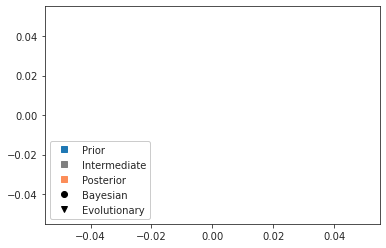

In [155]:
fig = plt.figure()
colors = ['#1f78b4', 'grey', '#fc8d59']
labels = ["Prior", "Intermediate", 'Posterior'] + ['Bayesian', "Evolutionary"]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", color) for color in colors]
handles += [f(marker, "k") for marker in markers]
plt.legend(handles, labels, loc=3, framealpha=1)
plt.show()

(107458,)
(6147,)


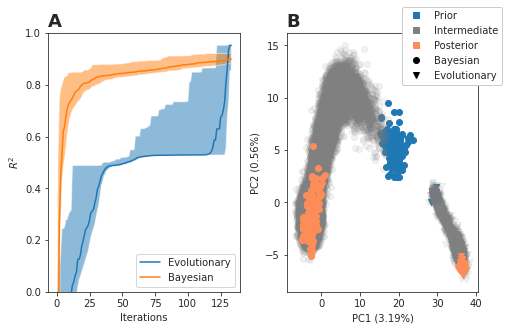

In [234]:
plt.figure(figsize=(3*2.3,2*2.3))
plt.subplot(1,2,1)
plt.title("A",loc="left",fontsize=18,fontweight="bold")
plot_convergence_and_compare_evolution(evolution_model, reference_model, maxiter = evolution_model.generations)
plt.subplot(1,2,2)
plt.title("B",loc="left",fontsize=18,fontweight="bold")
create_evo_pca_plot()
plt.savefig("../figures/evo_fig.png",dpi=600,bbox_inches = 'tight')

In [231]:
plt.savefig("../figures/evo_fig.png",dpi=1000)

<Figure size 432x288 with 0 Axes>

# Effects on pathway level

In [192]:
combined_list = [reference_model]
combined_list.extend(models)
combined_index = ['unpermuted']
combined_index.extend((f'permuted_{i}') for i in range(3))
combined_df = pd.DataFrame({'model' : combined_list},index=combined_index)

In [42]:
combined_df

,model
unpermuted,<abc_etc.SMCABC object at 0x7fb6b230e9a0>
permuted_0,<abc_etc.SMCABC object at 0x7fb7365c6ca0>
permuted_1,<abc_etc.SMCABC object at 0x7fb76c0b8250>
permuted_2,<abc_etc.SMCABC object at 0x7fb73649f280>
